In [41]:
import os
import yaml
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data

In [42]:
with open('../../data/post_test/rankings_scored.pkl', 'rb') as fp:
    rankings = pickle.load(fp)
    
prior = pd.read_csv('../../data/post_test/jade_prior_annotations.csv', sep='\t', index_col=0)
    
with open('../../data/experiment_keys/permutation_maps/vector_binary.yaml', 'r') as fp:
    permutation_map = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../visualisers/maps/concat_labels.yaml', 'r') as fp:
    palette = yaml.load(fp, Loader=yaml.FullLoader)
    palette = palette['vector_labels']
    palette['q1'] = '#8AB0AB'
    palette['q2'] = '#3E505B'
    palette['q3'] = '#F2F230'
    palette['q4'] = '#1A1D1A'

In [43]:
rankings_columns = [
    'username', 'field', 'level', 'year', 'consent', 'gender',
    'ranking', 'q1_conf', 'q2_conf', 'q3_conf', 'q4_conf', 
    'notes_text', 'notes_math', 'notes_table', 'notes_diag', 'notes_time', 
    'beerslaw', 'beerslaw_conf', 
    'feedback_entertain', 'feedback_difficult', 'feedback_good', 'feedback_bad', 'feedback',
    'q1_score', 'q2_score', 'q3_score', 'q4_score'
]
ranks = rankings[rankings_columns]
ranks['vector_label'] = ranks['ranking'].apply(lambda x: permutation_map['map'][x])

In [44]:
ranking_prior = rankings.merge(prior[['username', 'jade_label4']], on=['username'], how='inner')

In [45]:
print(len(ranking_prior), len(prior), len(rankings))

371 434 422


# Prior Levels

In [46]:
def extract_knowledge_level(label:str) -> str:
    labels = label.split(',')
    labels = label[0]
    return labels

ranking_prior['knowledge_prior'] = ranking_prior['jade_label4'].apply(extract_knowledge_level)

In [7]:
ranking_prior[]

SyntaxError: invalid syntax (3496410884.py, line 1)

In [53]:
def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_knowledge_prior(df, prior:str, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    subdf = get_sub_df(df, 'knowledge_prior', prior)
    subdf['plot_score'] = subdf['q1_score'] + subdf['q2_score'] + subdf['q3_score'] + subdf['q4_score']
    subdf['plot_confidence'] = subdf['q1_conf'].astype(int) + subdf['q2_conf'].astype(int) + subdf['q3_conf'].astype(int) + subdf['q4_conf'].astype(int)
    subdf['plot_confidence'] = subdf['plot_confidence'].apply(lambda x: float(x)/4)
    
    # scores
    scores = subdf['plot_score'].unique()
    scores.sort()
    
    x = []
    y = []
    confidences = []
    for i, score in enumerate(scores):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'plot_score', score)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=[palette[key] for key in palette][0:len(y)])
    # confidence boxplot
#     axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x) +1))
    axis.set_xticklabels([xx-1 for xx in x])
    axis.set_title('Level of knowledge: ' + prior)
    axis.set_ylim([0, 60])
    

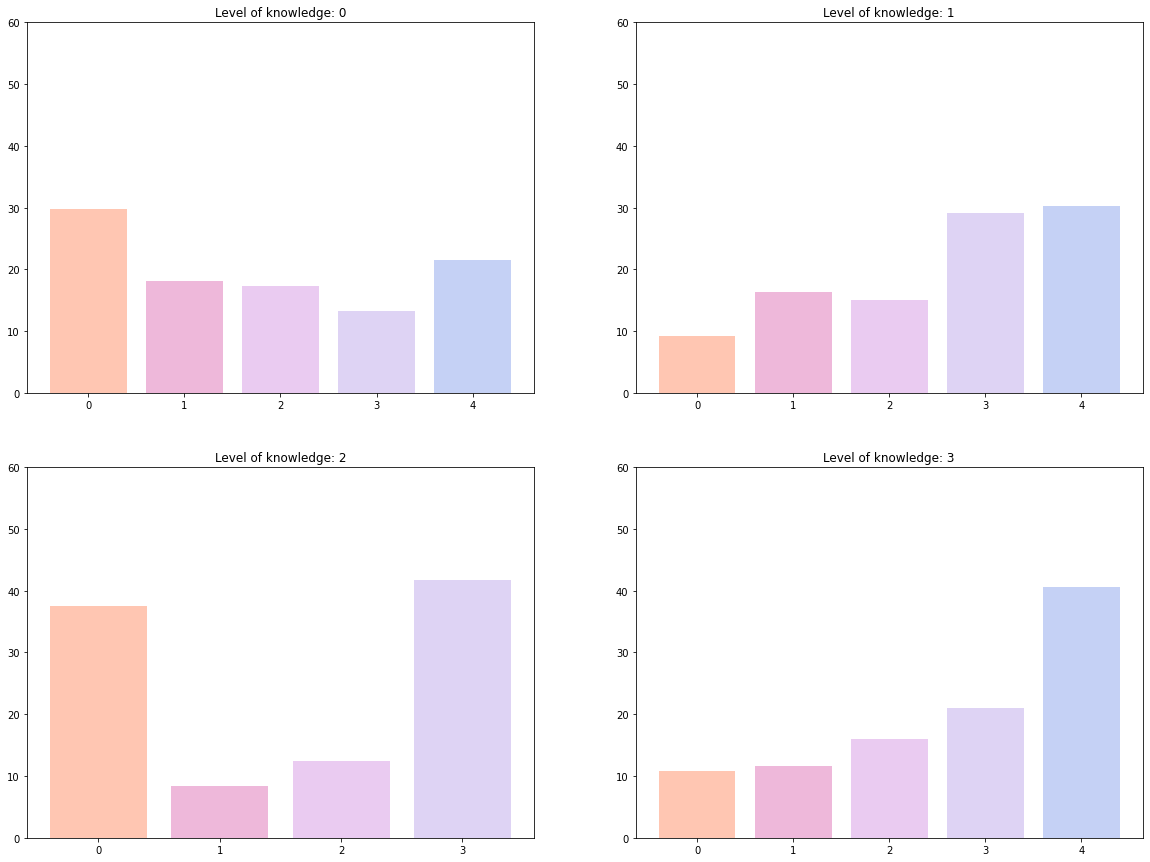

In [54]:
fig, axis = plt.subplots(2, 2, figsize=(20, 15))

plot_boxplot_knowledge_prior(ranking_prior, '0', axis[0, 0])
plot_boxplot_knowledge_prior(ranking_prior, '1', axis[0, 1])
plot_boxplot_knowledge_prior(ranking_prior, '2', axis[1, 0])
plot_boxplot_knowledge_prior(ranking_prior, '3', axis[1, 1])

# Scores

## Scores to Prior

In [10]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimum',
    '3': 'prior'
}

def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_prior(df, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/4)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # prior knowledge
    priors = subdf['knowledge_prior'].unique()
    priors = [p for p in priors if p in ['0', '1', '2', '3']]
    priors = [int(p) for p in priors]
    priors.sort()
    priors = [str(p) for p in priors]
    label_priors = [category_map[p] for p in priors]
    
    x = []
    y = []
    confidences = []
    for i, p in enumerate(priors):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'knowledge_prior', p)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=[palette[key] for key in palette][0:len(y)])
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(label_priors)
    axis.set_title('Score ' + str(score))
    

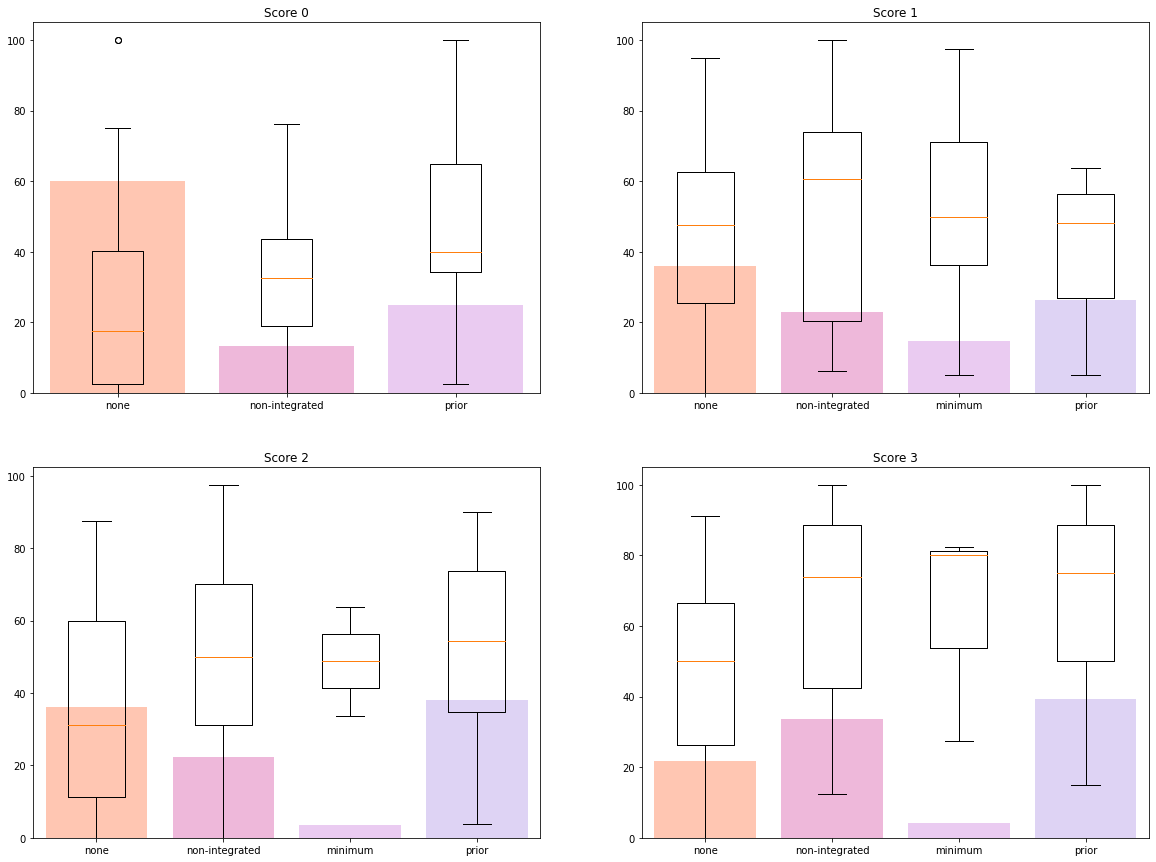

In [11]:
fig, axis = plt.subplots(2, 2, figsize=(20, 15))

plot_boxplot_score_to_prior(ranking_prior, 0, axis[0, 0])
plot_boxplot_score_to_prior(ranking_prior, 1, axis[0, 1])
plot_boxplot_score_to_prior(ranking_prior, 2, axis[1, 0])
plot_boxplot_score_to_prior(ranking_prior, 3, axis[1, 1])

## Scores to rankings

In [12]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimum',
    '3': 'prior'
}

def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_ranking(df, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/4)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # rankings
    rankings = subdf['ranking'].unique()
    
    x = []
    y = []
    confidences = []
    for i, r in enumerate(rankings):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'ranking', r)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=[palette[key] for key in palette][0:len(y)])
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(rankings)
    axis.set_title('Score ' + str(score))
    

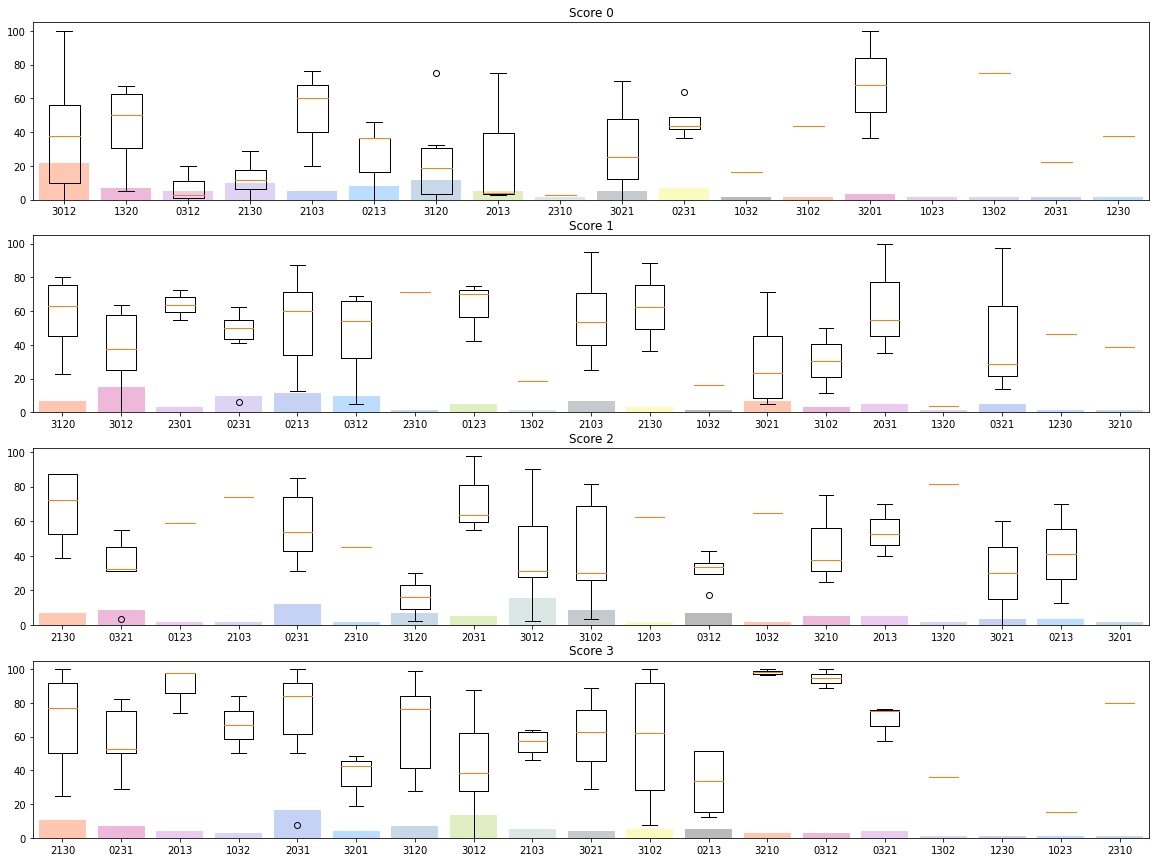

In [13]:
fig, axis = plt.subplots(4, 1, figsize=(20, 15))

plot_boxplot_score_to_ranking(ranking_prior, 0, axis[0])
plot_boxplot_score_to_ranking(ranking_prior, 1, axis[1])
plot_boxplot_score_to_ranking(ranking_prior, 2, axis[2])
plot_boxplot_score_to_ranking(ranking_prior, 3, axis[3])

In [39]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimum',
    '3': 'prior'
}

def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_permutationmap(df, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/4)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # rankings
    rankings = subdf['ranking'].unique()
    rankings_labels = [permutation_map['map'][r] for r in rankings]
    colours = [permutation_map['map'][r] for r in rankings]
    colours = [palette[c] for c in colours]
    indices = [(int(s[0]) + int(s[1]) + int(s[2])) for s in rankings_labels]
    indices = np.argsort(indices)
    rankings = [rankings[idx] for idx in indices]
    colours = [colours[idx] for idx in indices]
    rankings_labels = [rankings_labels[idx] for idx in indices]
    
    x = []
    y = []
    confidences = []
    for i, r in enumerate(rankings):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'ranking', r)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=colours)
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(rankings_labels)
    axis.set_title('Score ' + str(score))
    

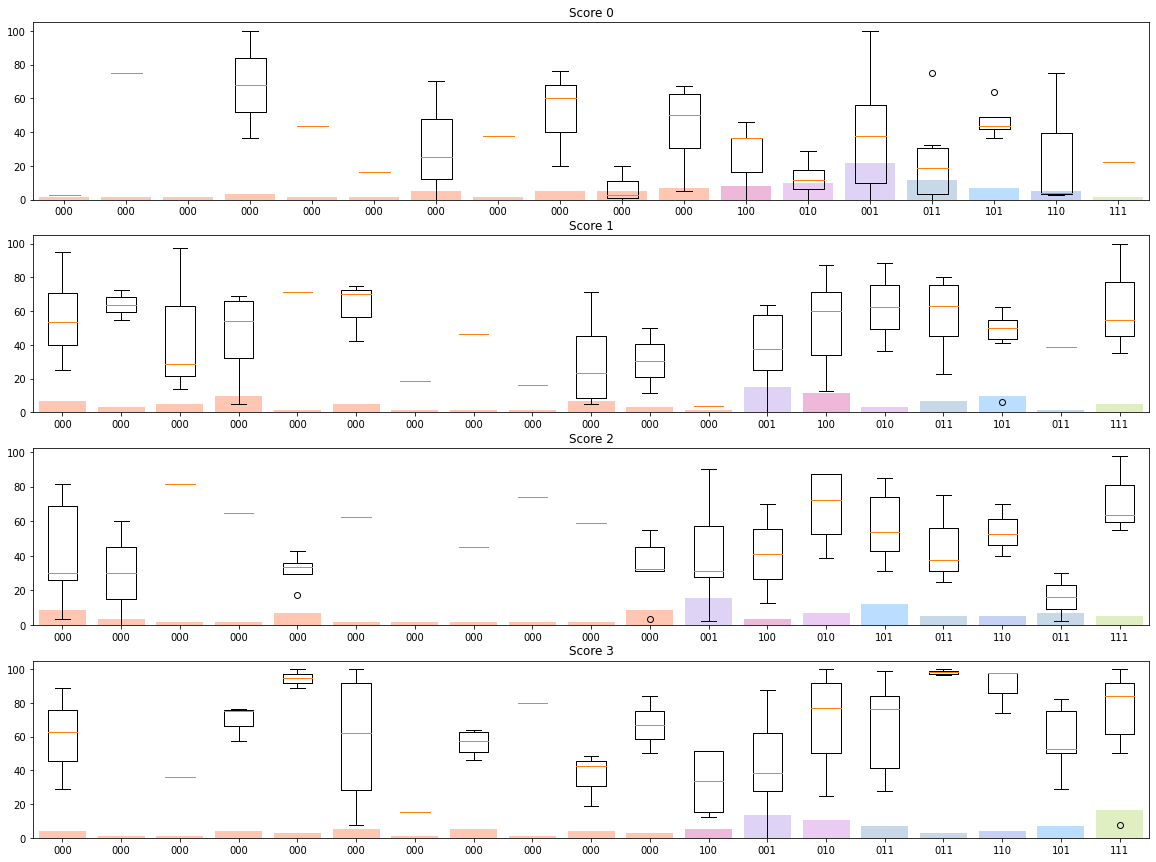

In [40]:
fig, axis = plt.subplots(4, 1, figsize=(20, 15))

plot_boxplot_score_to_permutationmap(ranking_prior, 0, axis[0])
plot_boxplot_score_to_permutationmap(ranking_prior, 1, axis[1])
plot_boxplot_score_to_permutationmap(ranking_prior, 2, axis[2])
plot_boxplot_score_to_permutationmap(ranking_prior, 3, axis[3])